## Task 3

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
torch.cuda.set_device(1)

In [3]:
img = torchvision.io.read_image("dog.jpg")
img.shape

torch.Size([3, 1365, 2048])

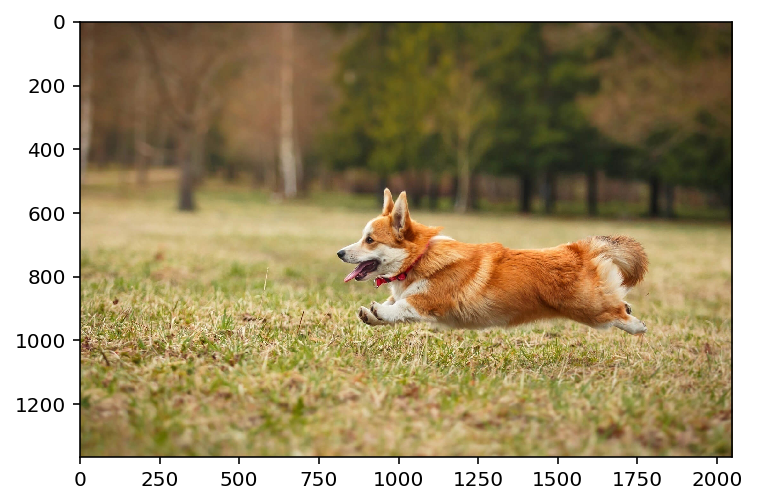

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

In [6]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2980, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3843, 0.3843],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3882, 0.3843],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3882, 0.3882]],

        [[0.2000, 0.2039, 0.2039,  ..., 0.2157, 0.2118, 0.2118],
         [0.2000, 0.2039, 0.2039,  ..., 0.2157, 0.2118, 0.2118],
         [0.2000, 0.2039, 0.2078,  ..., 0.2157, 0.2118, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4118,  ..., 0.3216, 0.3137, 0.3137],
         [0.4039, 0.4039, 0.4118,  ..., 0.3216, 0.3176, 0.3137],
         [0.4039, 0.4039, 0.4118,  ..., 0.3255, 0.3176, 0.3176]],

        [[0.1451, 0.1490, 0.1490,  ..., 0.1176, 0.1176, 0.1176],
         [0.1451, 0.1490, 0.1490,  ..., 0.1176, 0.1176, 0.1176],
         [0.1451, 0.1490, 0.1412,  ..., 0.1176, 0.1176, 0.

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

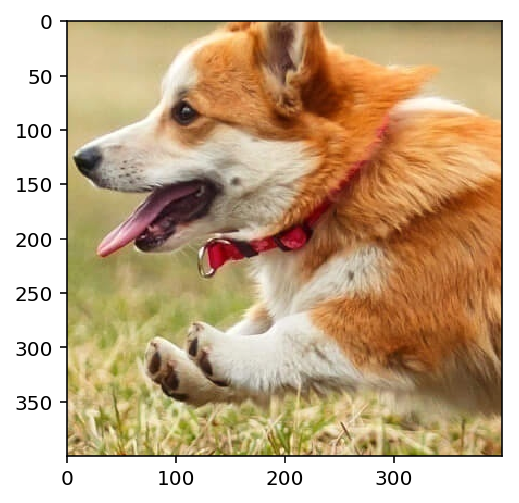

In [8]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
crop = crop.to(device)

### Resizing the image using OpenCv

In [10]:
import cv2

resized_crop = cv2.resize(rearrange(crop, 'c h w -> h w c').cpu().numpy(), (200, 200))

resized_crop = torch.tensor(resized_crop)

resized_crop = resized_crop.to(device)


In [11]:
resized_crop.shape

torch.Size([200, 200, 3])

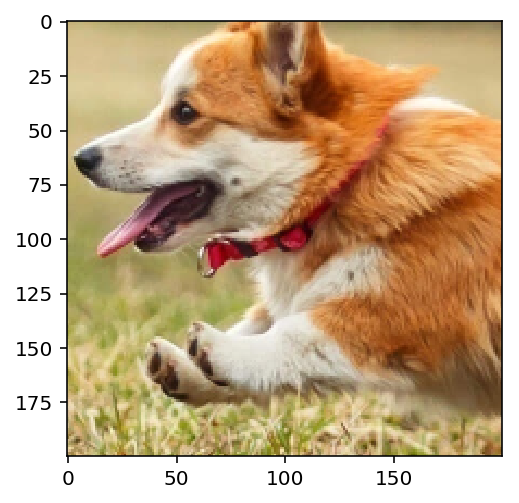

In [12]:
plt.imshow(resized_crop.cpu().numpy())

In [13]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (height, width , num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width , num_channels = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'h w c-> (h w) c').float()
    return X, Y

In [14]:
dog_X , dog_Y = create_coordinate_map(resized_crop)
print(f"X: {dog_X.shape}")
print(f"Y: {dog_Y.shape}")

X: torch.Size([40000, 2])
Y: torch.Size([40000, 3])


In [15]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled.shape)
dog_X_scaled

torch.Size([40000, 2])


tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]], device='cuda:1')

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [17]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 1000 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [18]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2) , random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [19]:
X_dog_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [20]:
print(f"X: {X_dog_rff.shape}")
print(f"Y: {dog_Y.shape}")

X: torch.Size([40000, 37500])
Y: torch.Size([40000, 3])


In [21]:
model = LinearModel(X_dog_rff.shape[1], dog_Y.shape[1])

model.to(device)

train(model, 0.005, X_dog_rff, dog_Y, 5000)

Epoch 0 loss: 0.369791
Epoch 1000 loss: 0.000221
Epoch 2000 loss: 0.000195
Epoch 3000 loss: 0.000192
Epoch 4000 loss: 0.000190


0.00018899953283835202

In [22]:
def create_coordinate_map2(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    height, width , ch = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    # Y = rearrange(img, 'c h w -> (h w) c').float()
    return X

In [23]:
resized_crop.shape

torch.Size([200, 200, 3])

In [24]:
dog_X_super  = create_coordinate_map2(resized_crop , scale=2)
print(f"X:{dog_X_super.shape}")
print(f"Y:{dog_Y.shape}")

dog_X_super

X:torch.Size([160000, 2])
Y:torch.Size([40000, 3])


tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [199.5000, 198.5000],
        [199.5000, 199.0000],
        [199.5000, 199.5000]], device='cuda:1')

In [25]:
super_scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_super.cpu())

# Scale the X coordinates
dog_X_super_scaled = super_scaler_X.transform(dog_X_super.cpu())

# Move the scaled X coordinates to the GPU
dog_X_super_scaled = torch.tensor(dog_X_super_scaled).to(device)

# Set to dtype float32
dog_X_super_scaled = dog_X_super_scaled.float()
dog_X_super_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:1')

In [26]:
def create_rff_features2(X, num_features, sigma, device):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np

    X_np = X.cpu().numpy()
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
    X_rff = rff.fit_transform(X_np)
    X_tensor = torch.tensor(X_rff, dtype=torch.float32, device=device)

    return X_tensor


In [27]:
dog_X_super_scaled_rff = create_rff_features2(dog_X_super_scaled, 37500, 0.008 ,device)

In [28]:
print(f"X: {dog_X_super_scaled_rff.shape}")
print(f"Y: {dog_Y.shape}")

X: torch.Size([160000, 37500])
Y: torch.Size([40000, 3])


In [29]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original 400x400 Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


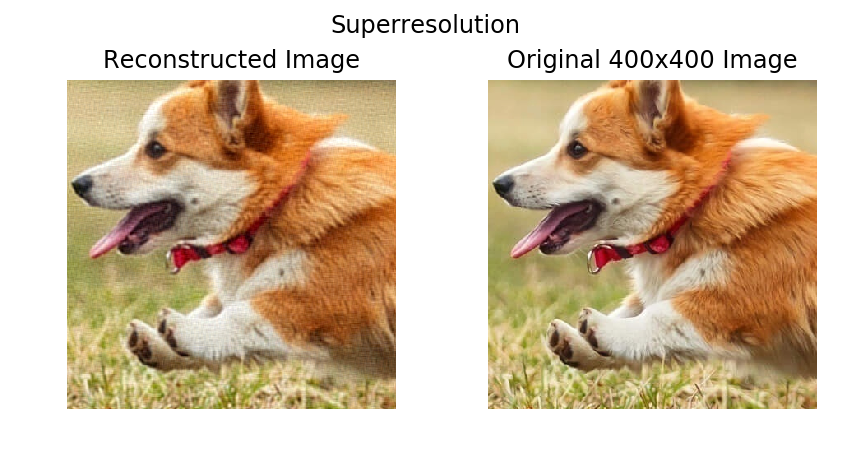

In [30]:
Output_Y = plot_reconstructed_and_original_image(crop, model , dog_X_super_scaled_rff , title="Superresolution")

In [31]:
mse = ((Output_Y.cpu().numpy() - rearrange(crop , 'c h w -> h w c').cpu().numpy())**2).sum() / (crop.shape[0]* crop.shape[1]* crop.shape[2])

rmse = np.sqrt(mse)
MAX=1.0 # MAX represents the maximum possible pixel value of the image (e.g., 255 for an 8-bit grayscale image or 1 for a normalized image).

PSNR = 10 * np.log10((MAX ** 2) / mse)

print('RMSE:', rmse)
print('Peak SNR:' , PSNR)

RMSE: 0.0333671588761757
Peak SNR: 29.53361541555789
